In [144]:
## MPHil in data intensive science
# Astronomy in the SKA-era mini project
# SKA-low mini project
# 01.03.2024
# Q. Gueuning (qdg20@cam.ac.uk) and O. O'Hara

import numpy as np
from harp_beam.harp_beam import compute_EEPs
import scipy.io
import matplotlib.pyplot as plt

In [145]:
# ## Q 2. plot all the 256 EEPs and their average (AEP)
# num_dir = 2  # number of samples along theta
# theta = np.array([0.0, np.pi/4.0])[:,None]  # angle from zenith in radians
# phi = np.array([np.pi/2.0, 0.0])[:,None]   # azimuth from x-axis in radians (from 0 to 2pi)
# # !! theta and phi must be vectors of the same size

In [146]:
# theta

In [147]:
# phi

In [148]:
# antenna positions loaded as follows
data_folder = 'harp_beam'
filename_eep = f"data_EEPs_SKALA41_random_100MHz.mat"
mat = scipy.io.loadmat(data_folder+"/"+filename_eep)
pos_ant = np.array(mat['pos_ant'])
x_pos = pos_ant[:,0]
y_pos = pos_ant[:,1]

In [149]:
# there is a total of 256 antennas, each is located by two coordinates (x,y)
pos_ant.shape

(256, 2)

In [150]:
# # the following function computes the theta and phi vector components of the 256 embedded element patterns
# # evaluated at coordinates "theta" and "phi" defined earlier by the user
# v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta, phi)

In [151]:
# v_theta_polY.shape

In [152]:
# these voltage matrices are of size num_theta*num_phi x num_ant
# The EEP of antenna i_ant at position pos_ant(i_ant,:) is in v[:, i_ant]

## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as
filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(data_folder + "/" + filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

In [153]:
# R is a 256x256 matrix
R.shape

(256, 256)

In [154]:
# Both M_AEP and M_EEPs are 256x256 matrices
M_AEP.shape, M_EEPs.shape

((256, 256), (256, 256))

In [155]:
# g_sol is a 256x1 vector, which is the diagonal component of the covariance matrix
g_sol.shape

(256, 1)

In [156]:
# np array of size 256x1
g = np.array([1.0]*256)

In [157]:
def frobenius_norm(A):
    """
    returns the Frobenius norm of a matrix A
    
    args:
    A: np.array of size (n,m)

    returns:
    float: Frobenius norm of A
    """
    if A.shape == (A.shape[0],):
        # if A is a vector, return its norm
        return np.linalg.norm(A)
    return np.linalg.norm(A, 'fro')

In [158]:
class G_solver:
    def __init__(self):
        """
        initializes the G_solver class
        
        args:
        None

        returns:
        None
        """

    def load_values(self, filename = f"harp_beam/data_20feb2024_2330_100MHz.mat"):
        """
        loads R, M, g_sol, g_AEP, g_EEPs from the .mat file
        
        args:
        g_sol: np.array of size (n,)

        returns:
        None
        """
        mat = scipy.io.loadmat(filename)
        self.R = np.array(mat['R']) # covariance matrix
        self.M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
        self.M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
        self.g_sol = np.array(mat['g_sol']) # exact gain solution
        self.g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
        self.g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs
        pass

    def estimate_g(self, R, M, G_init = np.array([1.0]* 256), iMax = 1000, tau = 1e-6):
        """
        estimates the gain vector g using the model matrix M and the covariance matrix R, using StEFCal

        args:
        G_init: np.array of size (n,)
        iMax: int
        tau: float

        returns:
        None
        """

        R = R.astype(complex)
        M = M.astype(complex)
        g = G_init.astype(complex)
        self.f_norm = []
        self.g_history = [G_init]
        for i in range (iMax):
            g_cache = g.copy()
            for p in range (256):
                z = g_cache * M[:,p]
                z.astype(complex)
                dot_product = np.dot(R[:,p].conj().T, z)
                dot_product.astype(complex)
                normalisation = np.dot(z.conj().T,z)
                normalisation.astype(complex)
                new_p = dot_product/normalisation
                g[p] = new_p
                g.astype(complex)
            self.g_history.append(g)
            self.f_norm.append(frobenius_norm(g - g_cache)/frobenius_norm(g))
            if i%2 == 0:
                if frobenius_norm(g - g_cache)/frobenius_norm(g) < tau:
                    # Convergence reached 
                    print ("Convergence reached at iteration ", i)
                    print ("Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g: ", frobenius_norm(g - g_cache)/frobenius_norm(g))
                    self.g_est = g
                    break
                else:
                    g = ((g+g_cache)/2)
        self.g_est = g

    def get_g_history(self):
        """
        returns a numpy array of estimated gain vectors
        
        args:
        None

        returns:
        list: list of estimated gain vectors
        """
        return np.array(self.g_history)
    
    def get_f_norm(self):
        """
        returns a numpy array of Frobenius norms
        
        args:
        None

        returns:
        list: list of Frobenius norms
        """
        return np.array(self.f_norm)


    def absolute_error(self):
        """
        returns the absolute error between the estimated gain and the exact gain
        
        args:
        None

        returns:
        float: absolute error between the estimated gain and the exact gain
        """
        no_iter = len(self.g_history)
        g_sol = self.g_sol
        g_history = self.g_history
        f_norm_history_abs = [np.mean(np.abs(np.abs(g_history[iter_])- np.abs(g_sol.flatten()))) for iter_ in range(no_iter)]
        f_norm_history_mag = [np.mean(np.abs(np.abs(g_history[iter_])- np.abs(g_sol.flatten()))) for iter_ in range(no_iter)]
        f_norm_history_angle = [np.mean(np.abs(np.angle(g_history[iter_])- np.angle(g_sol.flatten()))) for iter_ in range(no_iter)]
        return f_norm_history_abs, f_norm_history_mag, f_norm_history_angle
    
    def M_AEP_error(self):
        """
        returns the absolute error between the estimated gain using M_AEP and the exact gain
        
        args:
        None

        returns:
        float: absolute error between the estimated gain using M_AEP and the exact gain
        """
        g_history = self.g_history
        g_AEP = self.g_AEP
        f_norm_history_abs = [np.mean(np.abs(np.abs(g_history[iter_])- np.abs(g_AEP.flatten()))) for iter_ in range(len(g_history))]
        f_norm_history_mag = [np.mean(np.abs(np.abs(g_history[iter_])- np.abs(g_AEP.flatten()))) for iter_ in range(len(g_history))]
        f_norm_history_angle = [np.mean(np.abs(np.angle(g_history[iter_])- np.angle(g_AEP.flatten()))) for iter_ in range(len(g_history))]
        return f_norm_history_abs, f_norm_history_mag, f_norm_history_angle
    



In [159]:
solver = G_solver()
solver.load_values()
solver.estimate_g(solver.R, solver.M_AEP, np.array([1.0]* 256), 10000, 1e-3)

Convergence reached at iteration  40
Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g:  0.0009550080392948358


In [160]:
g_est = solver.g_est

In [161]:
g_init = np.array([1.0]* 256)
g_init = g_init.astype(complex)

In [162]:
len(solver.get_g_history()), len(solver.get_f_norm())

(42, 41)

In [163]:
np.mean(np.abs(np.abs(g_est) - np.abs(g_sol.flatten()))), np.mean(np.abs(np.abs(g_init) - np.abs(g_sol.flatten())))

(0.06500005826995595, 0.36546786304507173)

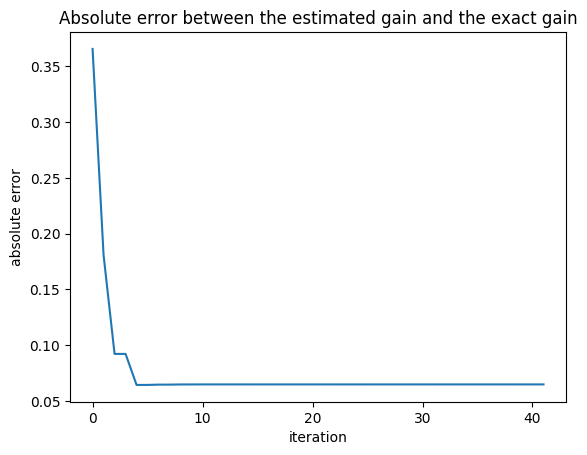

In [164]:
# plot the absolute error
plt.plot(solver.absolute_error()[0])
plt.xlabel('iteration')
plt.ylabel('absolute error')
plt.title('Absolute error between the estimated gain and the exact gain')
plt.show()


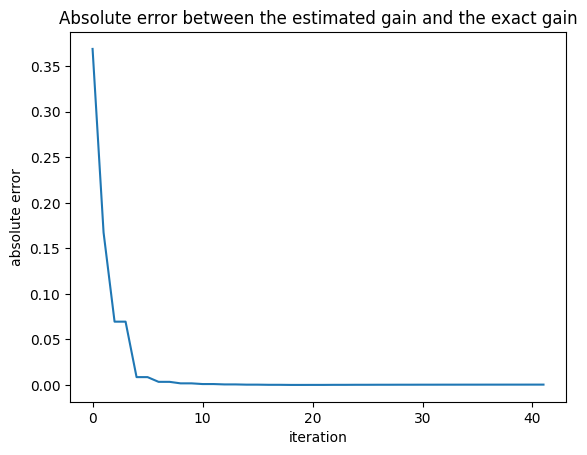

In [165]:
# plot the M_AEP error
plt.plot(solver.M_AEP_error()[0])
plt.xlabel('iteration')
plt.ylabel('absolute error')
plt.title('Absolute error between the estimated gain and the exact gain')
plt.show()

Text(0.5, 0, 'Number of iterations')

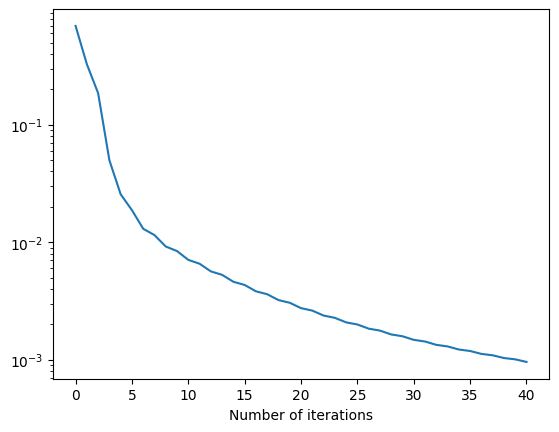

In [166]:
# plot the convergence of the algorithm
plt.plot(solver.f_norm)
plt.yscale('log')
plt.xlabel("Number of iterations")

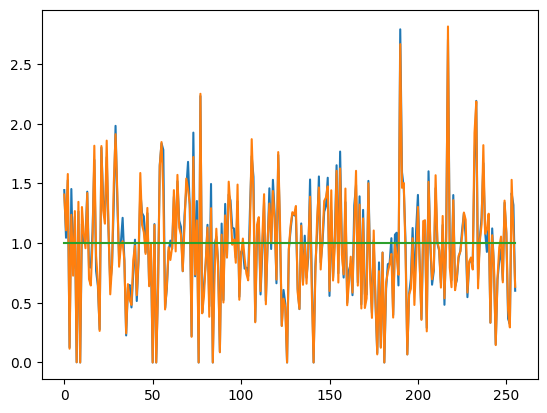

Frobenius norm of the difference between g_est and g_sol divided by the Frobenius norm of g_sol:  16.062607726635267


In [167]:
g_est = solver.g_est

# plot g_sol
plt.plot(np.abs(g_sol))

# plot algo(R, M_AEP, 10000)
plt.plot(np.abs(g_est))

# plot g_init
plt.plot(np.abs(np.array([1.0]* 256)))


plt.show()

print ("Frobenius norm of the difference between g_est and g_sol divided by the Frobenius norm of g_sol: ", frobenius_norm(g_est - g_sol)/frobenius_norm(g_sol))

In [168]:
f_norm = solver.f_norm

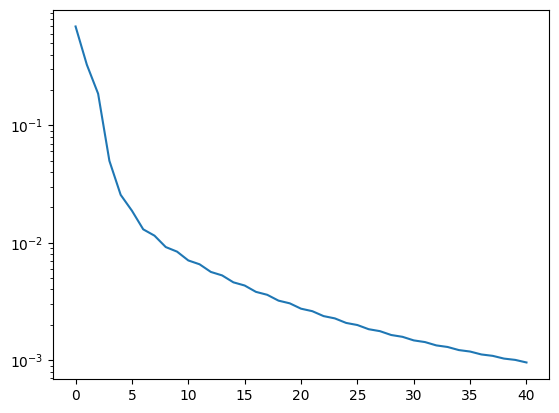

In [169]:
# plot f_norm
plt.plot(f_norm)
plt.yscale('log')
plt.show()

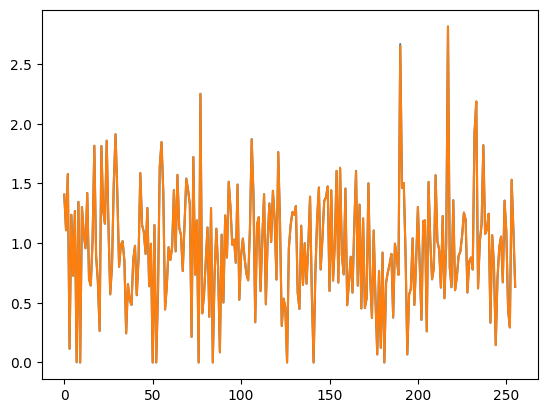

In [170]:
# plot g_est and g_AEP

plt.plot(np.abs(g_est))

plt.plot(np.abs(g_AEP))

plt.show()


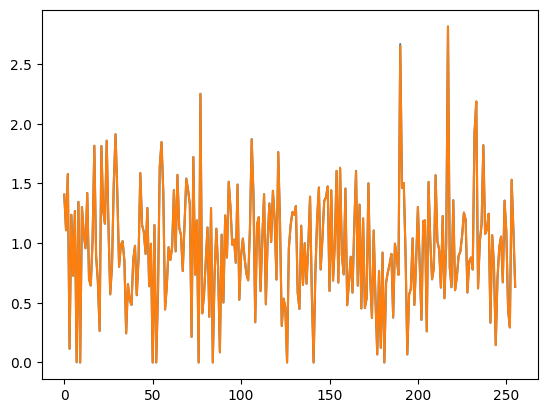

In [171]:
# plot the magnitude of the estimated gain vector and the exact gain vector
plt.plot(np.abs(g_est))

plt.plot(np.abs(g_AEP))

plt.show()

In [172]:
# 

In [173]:
def algo(R, M, iMax = 1000, tau = 1e-10, G_init = np.array([1.0]*256)):
    R = R.astype(complex)
    M = M.astype(complex)
    g = G_init.astype(complex)
    f_norm = np.array([])
    g_list = np.array([])
    for i in range (iMax):
        g_cache = g.copy()
        for p in range (256):
            z = g_cache * M[:,p]
            z.astype(complex)
            g[p] = np.dot(R[:,p].conj().T, z)/np.dot(z.conj().T,z)
            g.astype(complex)
        g_list = np.append(g_list, g)
        f_norm = np.append(f_norm, frobenius_norm(g - g_cache)/frobenius_norm(g))
        if i%2 == 0:
            if frobenius_norm(g - g_cache)/frobenius_norm(g) < tau:
                # Convergence reached 
                print ("Convergence reached at iteration ", i)
                print ("Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g: ", frobenius_norm(g - g_cache)/frobenius_norm(g))
                return g_cache, f_norm, g_list
            else:
                g = ((g+g_cache)/2)
        
    return g,f_norm, g_list

g_est, f_norm, g_list = algo(R, M_AEP, iMax = 10000, tau = 1e-15)

Convergence reached at iteration  1234
Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g:  9.80098698905642e-16
